# Fast Sampling with Gaussian Scale Mixture Priors

This notebook presents a fast sampling method for multivariate normal distributions with a particular form proposed in [Bhattacharya+ (2016)].

## Problem setting

Suppose we aim to sample from a $N$-dimensional multivariate normal distribution

$$
\begin{aligned}
    \theta &\sim \mathcal{N}_N (\theta | m, V)
\end{aligned}
$$

with

$$
\begin{aligned}
    m &= V \Phi^\top \alpha && \in \mathbb{R}^N, \\
    V &= \left( \Phi^\top \Phi + \Delta^{-1} \right)^{-1} && \in \mathbb{R}^{N \times N}.
\end{aligned}
$$

where $\Phi \in \mathbb{R}^{D \times N}$, $\alpha \in \mathbb{R}^D$, and $\Delta \in \mathbb{R}^{N \times N}$ is symmetric positive definite.

Ordinary algorithms [Rue (2001)] to sample from the distribution above face a bottleneck for large $N$ to perform a Cholesky decomposition of $V$ at each iteration, which requires $\mathcal O(N^3)$ operations.

The algorithm proposed in [Bhattacharya+ (2016)] is designed to overcome this bottleneck.

## The algorithm

This is the algorithm proposed in [Bhattacharya+ (2016)]:

1. sample $u \in \mathbb{R}^N$ from $\mathcal N_N(u | 0, \Delta)$.
2. sample $v \in \mathbb{R}^D$ from $\mathcal N_D(v | \Phi u, I_D)$.
3. solve $(\Phi \Delta \Phi^\top + I_D)w = (\alpha  - v)$ for $w$.
4. return $\theta = u + \Delta \Phi^\top w$.

As is clear from the algorithm, sampling is very fast especially when
- sampling from a multivariate normal distribution $\mathcal N_N(0, \Delta)$ is easy and/or
- $N \ll D$ is satisfied

Let us implement this algorithm and compare its performance with the ordinary `np.random.multivatiate_normal()` method.

In [1]:
import numpy as np
from typing import Optional

In [2]:
def sample_efficient(
    Phi: np.ndarray,
    alpha: np.ndarray,
    Delta: np.ndarray,
    seed: Optional[int] = None
) -> np.ndarray:
    rng = np.random.default_rng(seed)
    D = Phi.shape[0]
    N = Phi.shape[1]

    # Sample u from N(0, Delta)
    if np.isclose(np.diag(np.diag(Delta)), Delta).all():
        u = rng.normal(np.zeros(N), np.sqrt(np.diag(Delta)))
    else:
        u = rng.multivariate_normal(np.zeros(N), Delta)

    # Sample v from N(Phi @ u, I)
    v = rng.normal(Phi @ u, np.ones(D))

    # Solve for w
    w = np.linalg.solve(Phi @ Delta @ Phi.T + np.eye(D), alpha - v)

    return u + Delta @ Phi.T @ w

In [3]:
# set up random inputs

N = 1000
D = 100

Phi = np.random.randn(D, N)
alpha = np.random.rand(D)
Delta = np.diag(np.random.rand(N))

V = np.linalg.inv(Phi.T @ Phi + np.linalg.inv(Delta))
m = V @ Phi.T @ alpha

In [4]:
# speed test
from tqdm import tqdm
import time

start = time.time()
for _ in tqdm(range(10)):
    sample_efficient(Phi, alpha, Delta)
end = time.time()
time_efficient = end - start

start = time.time()
for _ in tqdm(range(10)):
    np.random.multivariate_normal(m, V)
end = time.time()
time_numpy = end - start

print(f"Efficient: {time_efficient:.3f}s")
print(f"Numpy: {time_numpy:.3f}s")

100%|██████████| 10/10 [00:07<00:00,  1.26it/s]

Efficient: 0.423s
Numpy: 7.916s


In [5]:
# Check that the results are almost the same
u1 = sample_efficient(Phi, alpha, Delta)
u2 = np.random.multivariate_normal(m, V)

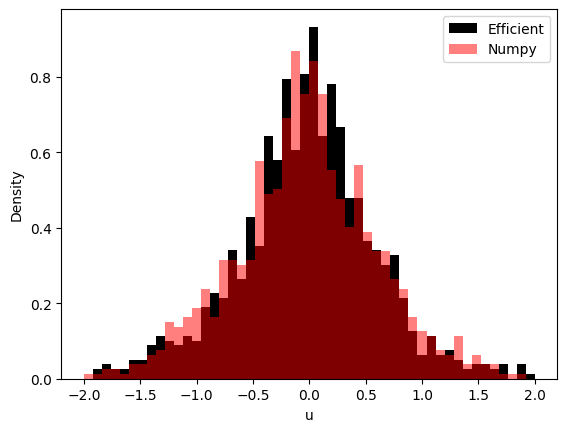

In [6]:
import matplotlib.pyplot as plt

plt.hist(u1, bins=50, color="k", alpha=1,   range=(-2, 2), density=True, label="Efficient")
plt.hist(u2, bins=50, color="r", alpha=0.5, range=(-2, 2), density=True, label="Numpy")
plt.legend()
plt.xlabel("u")
plt.ylabel("Density")
plt.show()

## Applications

The case above is common in linear regression. For example, when setting

$$
\begin{aligned}
    \Phi &= \frac{X}{\sigma_n}, &
    \alpha &= \frac{y}{\sigma_n}, &
    \Delta &= \tau^2 I,
\end{aligned}
$$

mean $m$ and covariance $V$ are given by

$$
\begin{aligned}
    m &= \frac{1}{\sigma_n^2} V X^\top y, \\
    V &= \sigma_n^2 \left( X^\top X + \frac{\sigma_n^2}{\tau^2} I \right)^{-1},
\end{aligned}
$$

which is same as the posterior distribution of the weights $w$ in linear regression $y^{(d)} = w^\top x^{(d)} + \varepsilon_n^{(d)}$ where $\varepsilon_n^{(d)} \sim \mathcal N(0, \sigma_n^2)$ with normal priors $w_i \sim \mathcal N(0, \tau^2)$.

In the similar way, by setting

$$
\begin{aligned}
    \Phi &= \frac{X}{\sigma_n}, &
    \alpha &= \frac{y}{\sigma_n}, &
    \Delta &= \sigma_n^2 \Lambda_\ast,
\end{aligned}
$$

mean $m$ and covariance $V$ become

$$
\begin{aligned}
    m &= A^{-1} X^\top y, \\
    V &= \sigma_n^2 A^{-1}, \\
    A &= X^\top X + \Lambda_\ast^{-1},
\end{aligned}
$$

which is used in the Bayesian linear regression with a Gaussian scale mixture prior, e.g., horseshoe prior [Makalic & Schmidt (2016)] and its application to the Thompson sampling [Baptista & Poloczek (2018)].

# References

- [Bhattacharya+ (2016)] A. Bhattacharya, A. Chakraborty, and B. K. Mallick, Fast Sampling with Gaussian Scale Mixture Priors in High-Dimensional Regression, Biometrika **103**, 985 (2016).
- [Rue (2001)] H. Rue, Fast Sampling of Gaussian Markov Random Fields, Journal of the Royal Statistical Society Series B: Statistical Methodology **63**, 325 (2001).
- [Makalic & Schmidt (2016)] E. Makalic and D. F. Schmidt, A Simple Sampler for the Horseshoe Estimator, IEEE Signal Processing Letters **23**, 179 (2016).
- [Baptista & Poloczek (2018)] R. Baptista and M. Poloczek, Bayesian Optimization of Combinatorial Structures, in Proceedings of the 35th International Conference on Machine Learning, edited by J. Dy and A. Krause, Vol. 80 (PMLR, 2018), pp. 462–471.